In [1]:
# Husayn El Sharif
comment = """
Use environment: env003 which has tensorflow support
use efficientnet from tensorhub and force 456 x 456 size
"""

In [ ]:
# TensorFlow Import and GPU Check

import tensorflow as tf
import tf_keras as keras # Import tf_keras for Keras 3 compatibility
import tensorflow_hub as hub

print("TF Version:", tf.__version__)
print("TF Hub Version:", hub.__version__)

# Check if GPU is savailable
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs available:")
    for gpu in gpus:
        print(f"- {gpu}")
else:
    print("No GPUs found.")

2026-01-04 12:50:11.438529: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-04 12:50:11.473730: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-04 12:50:12.408733: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/helsharif/miniconda3/envs/env003/lib/python3.11/site-packages/keras/src/export/tf2onn

TF Version: 2.20.0
TF Hub Version: 0.16.1
GPUs available:
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


/home/helsharif/miniconda3/envs/env003/lib/python3.11/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [3]:
# other imports
import numpy as np
import pandas as pd
import os
import glob

import datetime


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report


from IPython.display import Image

import matplotlib.pyplot as plt


import plotly.graph_objects as go
from plotly.subplots import make_subplots

import datetime

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report



In [4]:
# Use filenames and folders to get filepath and labels for all  images
all_imagefiles_list = glob.glob(
    'images/**/*.jpg', 
    recursive=True
)  # resized to 456x456 .jpg earlier

labels_temp = [filepath.split('/')[-2] for filepath in all_imagefiles_list]
patient_id = [f"{Path(filepath).stem.split('_')[0]}_{Path(filepath).parent.name}" for filepath in all_imagefiles_list]

# create dataframe with image_filepath, label
full_data_df = pd.DataFrame({
    'image_filepath': all_imagefiles_list,
    'label': labels_temp,
    'patient_id': patient_id
})

full_data_df


image_filepath     label    patient_id
0       images/cataract/0_4015166.jpg  cataract    0_cataract
1          images/cataract/0_left.jpg  cataract    0_cataract
2      images/cataract/100_334408.jpg  cataract  100_cataract
3     images/cataract/101_5139882.jpg  cataract  101_cataract
4      images/cataract/101_709333.jpg  cataract  101_cataract
...                               ...       ...           ...
4011        images/normal/8_right.jpg    normal      8_normal
4012       images/normal/939_left.jpg    normal    939_normal
4013      images/normal/939_right.jpg    normal    939_normal
4014       images/normal/951_left.jpg    normal    951_normal
4015      images/normal/951_right.jpg    normal    951_normal

[4016 rows x 3 columns]

In [5]:
# Split the full data into train, validation, and test sets based on patient_id. 
# Use 80% for training, 10% for validation, and 10% for testing.
# Split by patient_id ensures that images from the same patient do not appear in both training and validation sets or
# training and test sets, or validation and tests sets.
# As eye disease may affect both eyes, this is important to prevent data leakage.

train_ids, not_train_ids = train_test_split(
    full_data_df['patient_id'].unique(), 
    test_size=0.2, 
    random_state=42
)

val_ids, test_ids = train_test_split(
    not_train_ids, 
    test_size=0.5, 
    random_state=42
)

In [6]:
# create dataframes for train, validation, and test sets

train_df = full_data_df[full_data_df['patient_id'].isin(train_ids)].reset_index(drop=True)
val_df = full_data_df[full_data_df['patient_id'].isin(val_ids)].reset_index(drop=True)
test_df = full_data_df[full_data_df['patient_id'].isin(test_ids)].reset_index(drop=True)

In [7]:
# how many images of each label (in training data)?
print(train_df["label"].value_counts())
comment = """
Classes appear roughly balanced in quantity.
"""

label
diabetic_retinopathy    894
normal                  866
cataract                730
glaucoma                730
Name: count, dtype: int64


In [8]:
# how many images of each label (in validation data)?
print(val_df["label"].value_counts())
comment = """
Classes are reasonably balanced in quantity .
"""

label
normal                  126
diabetic_retinopathy    100
cataract                 88
glaucoma                 80
Name: count, dtype: int64


In [9]:
# how many images of each label (in test data)?
print(test_df["label"].value_counts())
comment = """
Classes are reasonablybalanced in quantity .
"""

label
cataract                120
diabetic_retinopathy    104
glaucoma                 96
normal                   82
Name: count, dtype: int64


In [10]:
# Create integer class labels
# Instead of one-hot booleans, we’ll use integer class indices (better for CrossEntropyLoss).

full_data_labels = full_data_df['label'].values.tolist()
unique_labels = sorted(np.unique(full_data_labels))  # e.g. ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

In [11]:
NUM_CLASSES = len(unique_labels)

In [12]:
# X_train and y_train 
train_labels = train_df['label'].values.tolist()

int_labels = [label_to_idx[label] for label in train_labels]

X_train = train_df["image_filepath"].tolist()
y_train = int_labels

In [13]:
# X_val and y_val 
val_labels = val_df['label'].values.tolist()

int_labels = [label_to_idx[label] for label in val_labels]

X_val = val_df["image_filepath"].tolist()
y_val = int_labels

In [14]:
# X_test and y_test 
test_labels = test_df['label'].values.tolist()

int_labels = [label_to_idx[label] for label in test_labels]

X_test = test_df["image_filepath"].tolist()
y_test = int_labels

In [15]:
# check lengths of split data
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)


(3220, 3220, 394, 394, 402, 402)

In [16]:
# parameter: image size (assuming square image size)

# parameter: image size 
IMG_SIZE_HEIGHT = 456 # recommended image size for EfficientNetB5
IMG_SIZE_WIDTH = 456
BATCH_SIZE = 32

In [17]:
# turn data into Tensors
# labels are already in numeric format
# so we need to process the images

# preprocessing images: turning images into tensors
# create helpful functions for pre-processing

comment = '''

1. take an image filepath as input
2. use TF to read the file and savite it to a variable, "image"
3. turn our "image" into a tensors
4. Normalize range of image channels from 0-255 to 0 - 1 (normalization)
5. resize images to be the same dimensions/size, namely shape (224, 224) for this project
6. return the modified image

helpful resources: 
https://www.tensorflow.org/guide/data
https://www.tensorflow.org/tutorials/load_data/images
'''
def process_image(image_path, img_height=IMG_SIZE_HEIGHT, img_width=IMG_SIZE_WIDTH ):
    '''
    Takes an image file path and turns image into a Tensor
    '''

    # read image file (from TF load images documentation)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)


    # Ensure square via padding before resize to avoid aspect distortion
    h = tf.shape(image)[0]
    w = tf.shape(image)[1]
    side = tf.maximum(h, w)
    image = tf.image.pad_to_bounding_box(image, (side - h)//2, (side - w)//2, side, side)
    

    
    # convert color channels from 0-255 to 0-1 values (Normalization)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    # resize image
    image = tf.image.resize(image, size=[img_height, img_width], method=tf.image.ResizeMethod.AREA)
    # return image converted to tensor
    return image


In [18]:
# turining our data into batches
comment = '''
Why turn our data into batches?
Speeds up processing compared to trying to process all 10,000+ images in one go. All those images will probably not fit into RAM or VRAM (GPU)
Batch size of 32 is recommended. So process 32 images at a time

To use TF, data needs to be in the form of a Tensor tuples which look like:
(image, label)
'''

# function to return a tuple (image, label)

def get_image_label(image_path, label, img_height=IMG_SIZE_HEIGHT, img_width=IMG_SIZE_WIDTH):
    '''
    Takes image file path name and its label,
    processes the images and retunrs a tuple of (image, label)
    '''
    image = process_image(image_path, img_height=img_height, img_width=img_width)
    return image, label

In [19]:
# turn all our data, X and y, into batches of size 32
comment = '''

'''

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, shuffle=False):
    '''
    Creates batches of data out of image X and label y pairs
    shuffles the data if its training data (precautionary measure)
    doesn't shuffle if it's validation data
    Also accepts test data as input (no labels)
    '''

    if shuffle == False:
        # do not shuffle data
        if y is None:
            print('Creating data batches, no y labels provided...') # test data
            data = tf.data.Dataset.from_tensor_slices( tf.constant(X) ) # only filepaths, no labels
            data_batch = data.map(process_image).batch(batch_size)
        else: # if y labels provided
            print('Creating data batches, y labels provided...') # validation data
            data = tf.data.Dataset.from_tensor_slices( (tf.constant(X), tf.constant(y, dtype=tf.float32)) ) # filepaths, labels
            data_batch = data.map(get_image_label).batch(batch_size)
    else:
        # do shuffle data
        if y is None:
            print('Creating data batches, no y labels provided. Shuffling data...') # ? no need to shuffle non-training data that has no labels provided
            data = tf.data.Dataset.from_tensor_slices( tf.constant(X) ) # only filepaths, no labels
            # shuffle all the data
            data = data.shuffle(buffer_size=len(X))
            data_batch = data.map(process_image).batch(batch_size)
        else: # if y labels provided
            print('Creating data batches, y labels provided. Shuffling data...') # training data
            data = tf.data.Dataset.from_tensor_slices( (tf.constant(X), tf.constant(y, dtype=tf.float32)) ) # filepaths, labels
            # shuffle all the data
            data = data.shuffle(buffer_size=len(X)) 
            # create (image, label) tuples
            data_batch = data.map(get_image_label).batch(batch_size)

    return data_batch

In [20]:
# create training and validation data batches
# shuffle training data just in case there is spurious structure in the ordering of the data that may adversely affect model training
train_data = create_data_batches(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)

Creating data batches, y labels provided. Shuffling data...


I0000 00:00:1767549014.141787   47215 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [21]:
# create validation data batches
val_data = create_data_batches(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False) # no need to shuffle validation data

Creating data batches, y labels provided...


In [22]:
# create test data batches
test_data = create_data_batches(X_test, y_test, batch_size=BATCH_SIZE, shuffle=False) # no need to shuffle test data

Creating data batches, y labels provided...


In [23]:
# check attriubutes of our data batches
train_data.element_spec, val_data.element_spec, test_data.element_spec

((TensorSpec(shape=(None, 456, 456, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 456, 456, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None, 456, 456, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None,), dtype=tf.float32, name=None)))

In [24]:
# pick a model from TensorFlow Hub that suits our problem (transfer learning)
comments = '''
Before we build a model, there are a few things we need to define
1. the input shape (in the form of tensors) to our model
2. the output shape (in the form of tensors) of our model
3. the URL of the model we want to use
'''

# setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH, 3] #[Batch, Height, Width, Color_Channels]

# output shape
OUTPUT_SHAPE = len(unique_labels) # an array of unique classification labels

# Setup model URL from TensorFlow Hub. See: https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b5-feature-vector/1
MODEL_URL = 'https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b5-feature-vector/1'

In [25]:
# Put it all together into a keras deep-learning model!
# use the TF keras API. Keras is a user friendly high level API for building tensorflow models
comment = '''
create function that takes input of 
input shape
output shape
model

Function defines layers in sequential fashion, compiles model, builds model, returns the model

see: https://www.tensorflow.org/guide/keras/overview
'''

def create_model( input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
    print("Building model with: ".format(model_url))

    # setup model layers
    model = keras.Sequential([
            hub.KerasLayer(model_url), # Layer 1 (input layer)
            keras.layers.Dense(units = output_shape, activation="softmax"), # Layer 2 (output layer), for multi-class classficiation use softmax activation       
        ])

    # compile model
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(), # for multi-class classficiation with integer labels use SparseCategoricalCrossentropy
        optimizer = keras.optimizers.Adam(),
        metrics=[
            "accuracy", # Fraction of correct predictions.
        ]
    )

    # build model
    model.build(input_shape)

    return model

In [26]:
# Create model and display summary
model = create_model( input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL )
model.summary()

Building model with: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              28513520  
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 28521716 (108.80 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 28513520 (108.77 MB)
_________________________________________________________________


In [27]:
# create callbacks: helper functions a model can use during training to save progress, check progress, or stop training early if model does not improve
# see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
comment = '''
To start a TensorBoard session from VSC:

1. Open the command palette (Ctrl/Cmd + Shift + P)
2. Search for the command “Python: Launch TensorBoard” and press enter.
3. You will be able to select the folder where your TensorBoard log files are located. 
   By default, the current working directory will be used.
'''




In [28]:
# create function to build a tensorboard callback
def create_tensorboard_callback():
    logdir = os.path.join("logs/",datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
    return keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
# create function to stop training if it is not improving significantly anymore. Early stopping. See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)


In [30]:
# model checkpoint
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath= os.path.join("saved_models_tensorflow/",datetime.datetime.now().strftime('%Y%m%d-%H%M%S'),'best_model.keras'), 
    save_weights_only=False, # Set to True if you only want to save weights
    monitor='val_accuracy', # Metric to monitor (e.g., 'val_accuracy', 'val_loss')
    mode='max', # 'min' for loss, 'max' for accuracy
    save_best_only=True,
)

In [31]:
# training a model on a subset of data (only 1000 images to make sure program works before training on 10,000+ images)
#NUM_EPOCHS = 10
NUM_EPOCHS = 50




In [32]:
# Train and return a trained model

def train_model():
    '''
    Trains a model and returns the trained version
    '''
    # create model
    model = create_model()

    # create new tensorboard session everytime we train a model
    tensorboard_callback = create_tensorboard_callback()

    # fit model, also passing it the callbacks
    model.fit(
        x=train_data, 
        epochs=NUM_EPOCHS,
        validation_data = val_data,
        validation_freq = 1,
        callbacks = [tensorboard_callback, early_stopping_callback, model_checkpoint_callback],
    )

    # return fitted model
    return model

In [33]:
# Fit model to data
model = train_model()

Building model with: 
Epoch 1/50


2026-01-04 12:50:46.086333: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500
2026-01-04 12:50:47.297200: I external/local_xla/xla/service/service.cc:163] XLA service 0x7180645021e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-04 12:50:47.297228: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2026-01-04 12:50:47.304938: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1767549047.461938   47300 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


101/101 [==============================] - 99s 842ms/step - loss: 0.6637 - accuracy: 0.7711 - val_loss: 0.4526 - val_accuracy: 0.8325
Epoch 2/50
101/101 [==============================] - 108s 1s/step - loss: 0.4136 - accuracy: 0.8559 - val_loss: 0.3672 - val_accuracy: 0.8756
Epoch 3/50
101/101 [==============================] - 107s 1s/step - loss: 0.3549 - accuracy: 0.8748 - val_loss: 0.3356 - val_accuracy: 0.8731
Epoch 4/50
101/101 [==============================] - 96s 950ms/step - loss: 0.3281 - accuracy: 0.8860 - val_loss: 0.3025 - val_accuracy: 0.9086
Epoch 5/50
101/101 [==============================] - 82s 808ms/step - loss: 0.2983 - accuracy: 0.8935 - val_loss: 0.2906 - val_accuracy: 0.9188
Epoch 6/50
101/101 [==============================] - 102s 1s/step - loss: 0.2791 - accuracy: 0.9012 - val_loss: 0.2732 - val_accuracy: 0.9239
Epoch 7/50
101/101 [==============================] - 113s 1s/step - loss: 0.2702 - accuracy: 0.9040 - val_loss: 0.2965 - val_accuracy: 0.9010
Epoc

In [34]:
# Load Best Model
search_pattern = 'saved_models_tensorflow/**/best_model.keras'
list_of_files = glob.glob(search_pattern, recursive=True)

if not list_of_files:
    print("No file named 'best_model.keras' found in 'saved_models_tensorflow' subfolders.")
else:
    # Find the file with the maximum creation time (os.path.getctime)
    # or modification time (os.path.getmtime)
    latest_file = max(list_of_files, key=os.path.getctime)
    print(f"The latest created file is: {latest_file}")


The latest created file is: saved_models_tensorflow/20260104-125025/best_model.keras


In [35]:
# try loading the best model
# note, need to add custom_objects={"KerasLayer":hub.KerasLayer} because of using TensorHub
loaded_best_model = keras.models.load_model(latest_file, custom_objects={"KerasLayer":hub.KerasLayer})

In [36]:
AUTOTUNE = tf.data.AUTOTUNE


def make_dataset(image_paths, labels=None, batch_size=32, shuffle=False):
    """
    Creates a tf.data.Dataset yielding (image, label) if labels provided else just image.
    IMPORTANT: shuffle=False preserves order so predictions align with image_paths.
    """
    if labels is None:
        ds = tf.data.Dataset.from_tensor_slices(tf.constant(image_paths))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(image_paths), reshuffle_each_iteration=True)
        ds = ds.map(lambda p: process_image(p), num_parallel_calls=AUTOTUNE)
    else:
        ds = tf.data.Dataset.from_tensor_slices((tf.constant(image_paths), tf.constant(labels)))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(image_paths), reshuffle_each_iteration=True)
        ds = ds.map(lambda p, y: (process_image(p), y), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds



def build_results_df(model, image_paths, y_int, idx_to_label, batch_size=32):
    """
    Returns a DataFrame with True_Label, Prediction_Label, Image_Path.
    Assumes y_int are integer class indices (Sparse labels).
    """
    # dataset MUST be shuffle=False to preserve alignment with image_paths
    ds = make_dataset(image_paths, labels=y_int, batch_size=batch_size, shuffle=False)

    pred_probs = model.predict(ds, verbose=1)
    pred_idx = np.argmax(pred_probs, axis=1)

    true_labels = [idx_to_label[int(i)] for i in y_int]
    pred_labels = [idx_to_label[int(i)] for i in pred_idx]

    return pd.DataFrame({
        "True_Label": true_labels,
        "Prediction_Label": pred_labels,
        "Image_Path": list(image_paths),
    })

In [37]:
train_image_paths =train_df['image_filepath'].values.tolist()
y_train_int = train_df['label'].map(label_to_idx).values.tolist()


train_results_df = build_results_df(
    model=loaded_best_model,
    image_paths=train_image_paths,
    y_int=y_train_int,
    idx_to_label=idx_to_label,
    batch_size=32
)

train_results_df

101/101 [==============================] - 70s 688ms/step


True_Label Prediction_Label                       Image_Path
0      cataract         cataract    images/cataract/0_4015166.jpg
1      cataract         cataract       images/cataract/0_left.jpg
2      cataract         cataract   images/cataract/100_334408.jpg
3      cataract         cataract  images/cataract/101_5139882.jpg
4      cataract         cataract   images/cataract/101_709333.jpg
...         ...              ...                              ...
3215     normal           normal        images/normal/8_right.jpg
3216     normal           normal       images/normal/939_left.jpg
3217     normal           normal      images/normal/939_right.jpg
3218     normal           normal       images/normal/951_left.jpg
3219     normal           normal      images/normal/951_right.jpg

[3220 rows x 3 columns]

In [38]:
val_image_paths = val_df['image_filepath'].values.tolist()
y_val_int = val_df['label'].map(label_to_idx).values.tolist()


val_results_df = build_results_df(
    model=loaded_best_model,
    image_paths=val_image_paths,
    y_int=y_val_int,
    idx_to_label=idx_to_label,
    batch_size=32
)

val_results_df

13/13 [==============================] - 9s 700ms/step


True_Label Prediction_Label                       Image_Path
0     cataract         cataract    images/cataract/1164_left.jpg
1     cataract         cataract  images/cataract/134_4903477.jpg
2     cataract         cataract  images/cataract/137_7856304.jpg
3     cataract         cataract  images/cataract/147_3710804.jpg
4     cataract         cataract  images/cataract/147_3796034.jpg
..         ...              ...                              ...
389     normal           normal     images/normal/3426_right.jpg
390     normal           normal     images/normal/3428_right.jpg
391     normal           normal      images/normal/3446_left.jpg
392     normal           normal     images/normal/3446_right.jpg
393     normal           normal      images/normal/3485_left.jpg

[394 rows x 3 columns]

In [39]:
test_image_paths = test_df['image_filepath'].values.tolist()
y_test_int = test_df['label'].map(label_to_idx).values.tolist()


test_results_df = build_results_df(
    model=loaded_best_model,
    image_paths=test_image_paths,
    y_int=y_test_int,
    idx_to_label=idx_to_label,
    batch_size=32
)   


test_results_df

13/13 [==============================] - 10s 831ms/step


True_Label Prediction_Label                       Image_Path
0     cataract         cataract  images/cataract/111_9826667.jpg
1     cataract         cataract  images/cataract/118_6296686.jpg
2     cataract         cataract  images/cataract/130_3561448.jpg
3     cataract         cataract  images/cataract/130_7837321.jpg
4     cataract           normal    images/cataract/1415_left.jpg
..         ...              ...                              ...
397     normal           normal     images/normal/3364_right.jpg
398     normal           normal      images/normal/3388_left.jpg
399     normal         cataract     images/normal/3388_right.jpg
400     normal           normal      images/normal/3393_left.jpg
401     normal           normal      images/normal/3427_left.jpg

[402 rows x 3 columns]

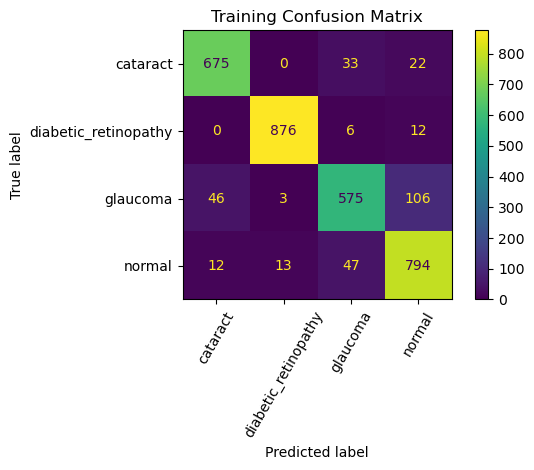

In [40]:
# Confusion Matrix for Training Data

cm_train = confusion_matrix(
    y_true=train_results_df["True_Label"],
    y_pred=train_results_df["Prediction_Label"],
    labels=unique_labels  # ensures consistent class order
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_train,
    display_labels=unique_labels
)

disp.plot(xticks_rotation=60, values_format="d")
plt.title("Training Confusion Matrix")
plt.tight_layout()
plt.show()


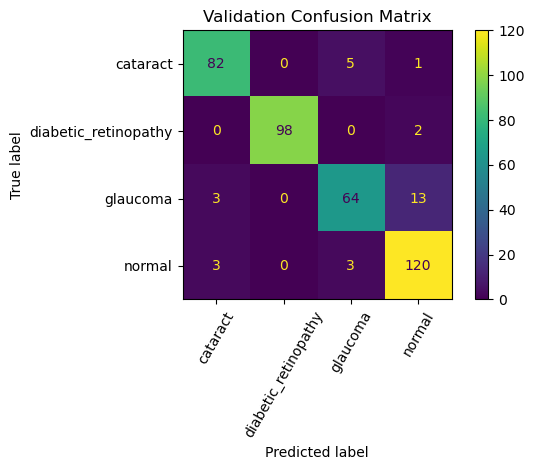

In [41]:
# Confusion Matrix for Validation Data

cm_val = confusion_matrix(
    y_true=val_results_df["True_Label"],
    y_pred=val_results_df["Prediction_Label"],
    labels=unique_labels  # ensures consistent class order
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_val,
    display_labels=unique_labels
)

disp.plot(xticks_rotation=60, values_format="d")
plt.title("Validation Confusion Matrix")
plt.tight_layout()
plt.show()


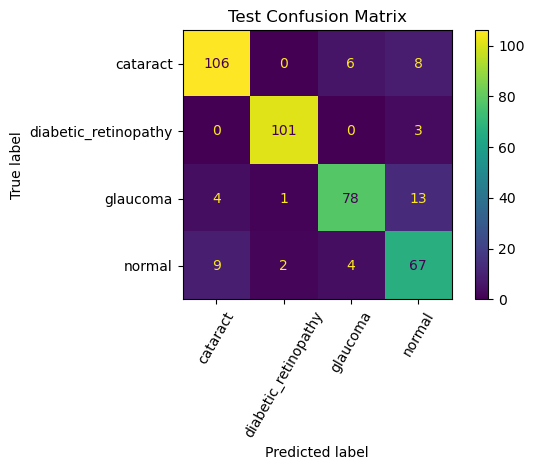

In [42]:
# Confusion Matrix for Test Data

cm_test = confusion_matrix(
    y_true=test_results_df["True_Label"],
    y_pred=test_results_df["Prediction_Label"],
    labels=unique_labels  # ensures consistent class order
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_test,
    display_labels=unique_labels
)

disp.plot(xticks_rotation=60, values_format="d")
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()


In [43]:
# Train Classification Report

train_report = classification_report(train_results_df['True_Label'], train_results_df['Prediction_Label'])
print(train_report)

                      precision    recall  f1-score   support

            cataract       0.92      0.92      0.92       730
diabetic_retinopathy       0.98      0.98      0.98       894
            glaucoma       0.87      0.79      0.83       730
              normal       0.85      0.92      0.88       866

            accuracy                           0.91      3220
           macro avg       0.91      0.90      0.90      3220
        weighted avg       0.91      0.91      0.91      3220



In [44]:
# Validation Classification Report

val_report = classification_report(val_results_df['True_Label'], val_results_df['Prediction_Label'])
print(val_report)

                      precision    recall  f1-score   support

            cataract       0.93      0.93      0.93        88
diabetic_retinopathy       1.00      0.98      0.99       100
            glaucoma       0.89      0.80      0.84        80
              normal       0.88      0.95      0.92       126

            accuracy                           0.92       394
           macro avg       0.93      0.92      0.92       394
        weighted avg       0.92      0.92      0.92       394



In [45]:
# Test Classification Report

test_report = classification_report(test_results_df['True_Label'], test_results_df['Prediction_Label'])
print(test_report)

                      precision    recall  f1-score   support

            cataract       0.89      0.88      0.89       120
diabetic_retinopathy       0.97      0.97      0.97       104
            glaucoma       0.89      0.81      0.85        96
              normal       0.74      0.82      0.77        82

            accuracy                           0.88       402
           macro avg       0.87      0.87      0.87       402
        weighted avg       0.88      0.88      0.88       402



In [ ]:

# # Figures Test Results (Plotly)

# num_rows = np.ceil(np.sqrt(len(Test_Results_df))).astype(int)
# num_cols = num_rows

# df = Test_Results_df.head(100)  # shorthand, first 100 rows
# n = len(df)
# grid = int(np.ceil(np.sqrt(n)))

# # Create list of subplot titles
# titles = [
#     f"True Label: {row['True_Label']}<br>Predicted: {row['Prediction_Label']}"
#     for _, row in df.iterrows()
# ]

# # create figure
# fig = make_subplots(rows=grid, cols=grid, subplot_titles=titles, vertical_spacing=0.02, horizontal_spacing=0.01)



# def to_uint8(img):
#     """Ensure image is uint8 RGB for Plotly."""
#     arr = np.asarray(img)
#     if arr.dtype == np.uint8:
#         return arr
#     # If floats in [0,1], scale up; otherwise clip to [0,255]
#     if np.issubdtype(arr.dtype, np.floating) and arr.max() <= 1.0:
#         arr = (np.clip(arr, 0.0, 1.0) * 255).astype(np.uint8)
#     else:
#         arr = np.clip(arr, 0, 255).astype(np.uint8)
#     return arr

# for idx, img in enumerate(df["Image_Data"]):
#     r = idx // grid + 1
#     c = idx % grid + 1
#     img_u8 = to_uint8(img)            # expects shape (H, W, 3)
#     fig.add_trace(go.Image(z=img_u8), row=r, col=c)

# # Hide ticks/axes and keep a nice square layout
# fig.update_xaxes(visible=False)
# fig.update_yaxes(visible=False)

# # Optional: make figure size scale with grid
# fig.update_layout(
#     showlegend=False,
#     #margin=dict(l=10, r=10, t=10, b=10),
#     height=grid * 200,
#     width=grid * 200,
#     font=dict(size=2)
# )

# # Update the font size of all annotations (subplot titles)
# fig.update_annotations(font_size=12) # Change 12 to your desired font size

# fig.show()



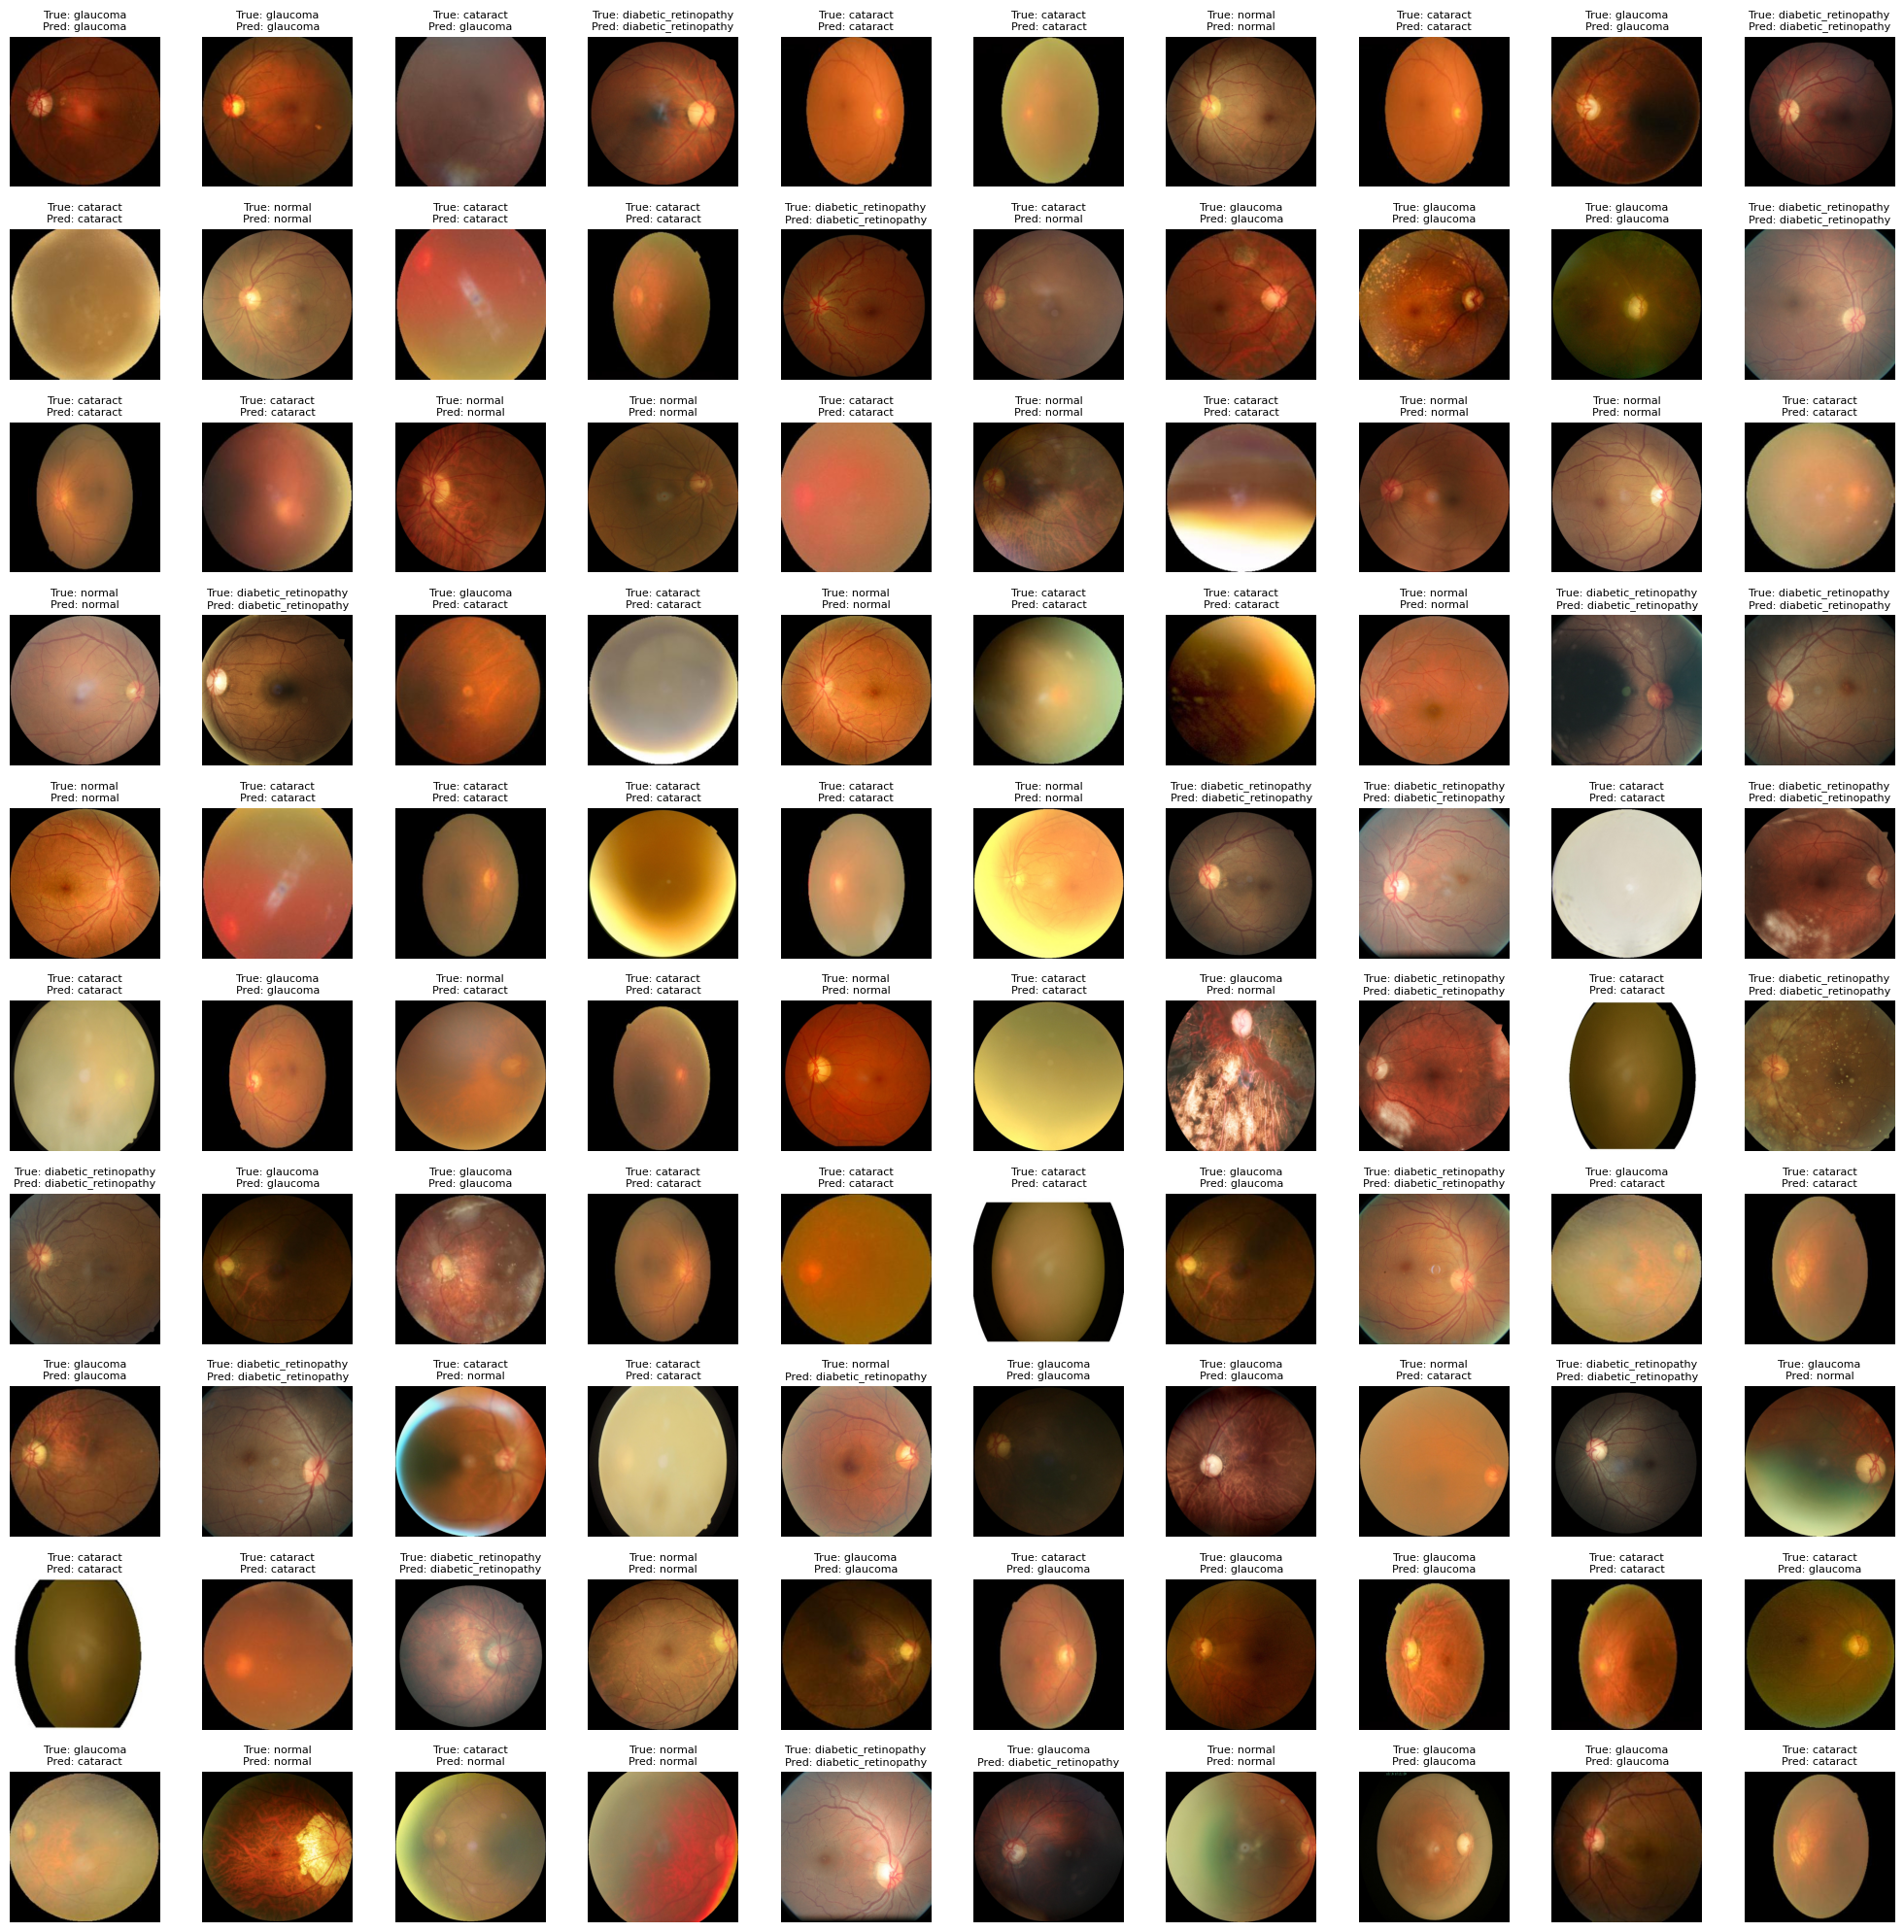

In [49]:
# Figure using Matplotlib

import matplotlib.pyplot as plt

# --- Helper to ensure uint8 ---
def to_uint8(img):
    arr = np.asarray(img)
    if arr.dtype == np.uint8:
        return arr
    if np.issubdtype(arr.dtype, np.floating) and arr.max() <= 1.0:
        arr = (np.clip(arr, 0.0, 1.0) * 255).astype(np.uint8)
    else:
        arr = np.clip(arr, 0, 255).astype(np.uint8)
    return arr

# --- Setup Data ---
df = test_results_df.sample(n=100, random_state=42)  # random sample of 100 rows
n = len(df)
grid = int(np.ceil(np.sqrt(n)))

# --- Create Matplotlib Figure ---
fig, axes = plt.subplots(grid, grid, figsize=(grid * 2, grid * 2))
axes = axes.flatten()

for idx, (_, row) in enumerate(df.iterrows()):
    ax = axes[idx]

    # 🔑 Load image from path
    img = tf.keras.utils.load_img(row["Image_Path"])
    img = tf.keras.utils.img_to_array(img)
    img = to_uint8(img)

    ax.imshow(img)
    ax.set_title(
        f"True: {row['True_Label']}\nPred: {row['Prediction_Label']}",
        fontsize=8
    )
    ax.axis("off")

# Turn off extra subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [50]:
# Write a csv file of test_df with predictions
timestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
output_csv_path = f"test_results_with_predictions_tensorflow_{timestamp}.csv"
test_results_df.to_csv(output_csv_path, index=False)
print(f"Test results with predictions saved to {output_csv_path}")

Test results with predictions saved to test_results_with_predictions_tensorflow_20260104-134551.csv


In [55]:
# Prediction for single image given image filepath

def predict_single_image(
    model,
    image_path,
    idx_to_label,
    image_size=(IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH)
):
    # Load and preprocess image
    img = tf.keras.utils.load_img(
        image_path,
        target_size=image_size
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, axis=0)  # (1, H, W, 3)

    # Predict
    probs = model.predict(img_array, verbose=0)
    pred_idx = int(np.argmax(probs, axis=1)[0])
    confidence = float(np.max(probs))

    return {
        "predicted_label": idx_to_label[pred_idx],
        "confidence": confidence,
        "raw_probs": probs[0],
        "labels_raw_probs": unique_labels,
    }

In [ ]:
result = predict_single_image(
    model=loaded_best_model,
    image_path="images/cataract/111_9826667.jpg", # from test set
    idx_to_label=idx_to_label,
    image_size=(IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH)
)

print(result)

{'predicted_label': np.str_('cataract'), 'confidence': 0.5011725425720215, 'raw_probs': array([5.0117254e-01, 4.9882731e-01, 1.2329532e-11, 1.5441063e-07],
      dtype=float32), 'labels_raw_probs': [np.str_('cataract'), np.str_('diabetic_retinopathy'), np.str_('glaucoma'), np.str_('normal')]}
